# Intro

OpenAI's CLIP (Contrastive Language-Image Pretraining) model is a machine learning model designed to understand and generate meaningful representations of images and text. It is trained on a large dataset of images and their associated textual descriptions, learning to associate images with their corresponding text.
The key innovation in CLIP is its use of contrastive learning, which involves training the model to recognize the correct pairing of an image and its description among a set of incorrect pairings. This approach enables the model to learn a wide range of visual concepts and their textual representations, making it capable of performing various tasks, such as image classification, object detection, and zero-shot learning.
CLIP's ability to understand both images and text allows it to be used in a variety of applications, including image search, content moderation, and generating image captions. Its versatility and performance have made it a popular choice for researchers and developers working on computer vision and natural language processing tasks.

In this notebook we are going to use a pretrained CLIP model for zero-shot object detection.

# Imports

In [2]:
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wmnezio5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wmnezio5
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=bcde432303319cfe401342e7bddbe04bcac15eccb2cfbcfb4823cc52438802e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-uflpwt80/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import clip
import torch
import requests
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# Data

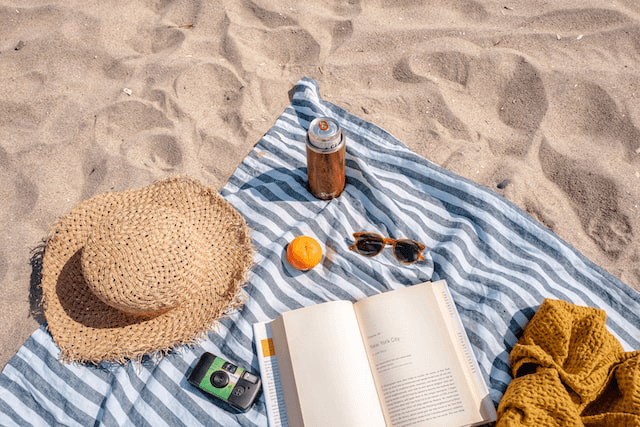

In [4]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")
img

# Extracting candidate regions

For this part use the RegionProposalNetwork in a pretrained faster rcnn to extract some candidate regions of different objects. Then visualize all the bounding boxes. You should get an image like this:

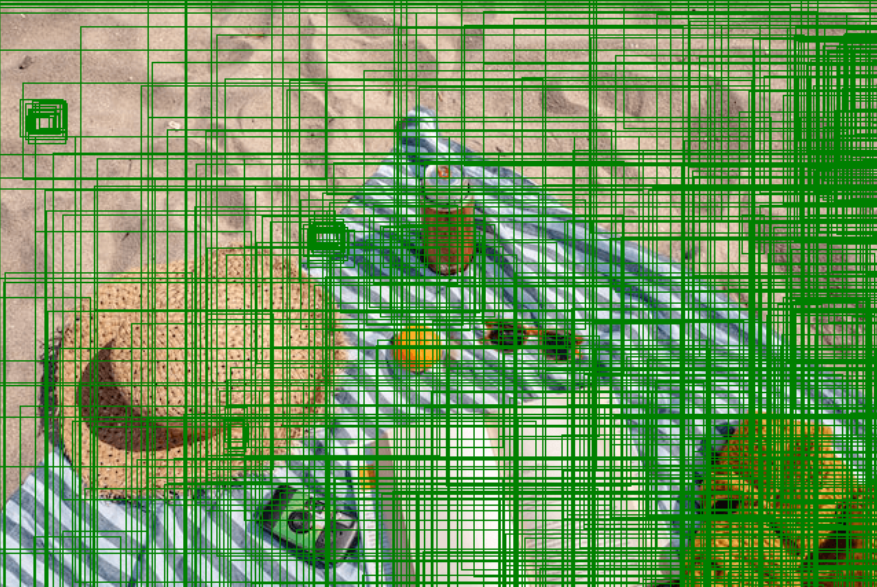

number of detected regions:  23


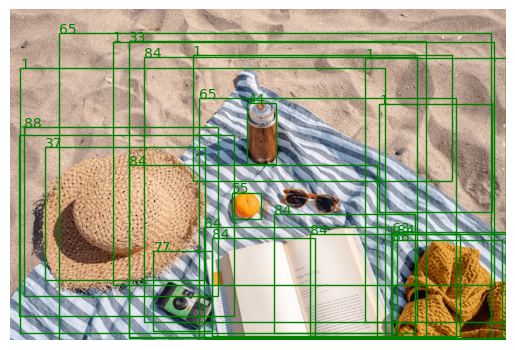

label :  44


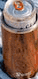

label :  88


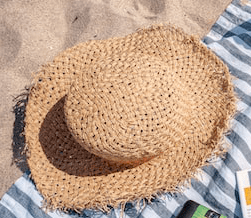

label :  63


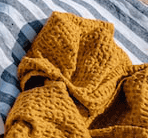

In [45]:
response = requests.get('https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png')
img = Image.open(BytesIO(response.content)).convert("RGB")

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    box_detections_per_img=200)
faster_rcnn.eval()

# =========================== BEGIN ===========================
def display_crop_patches(labels, boxes, img):
  cropped_images = []
  if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
  fig, ax = plt.subplots(1)
  plt.axis('off')
  ax.imshow(np.array(img))
  for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i]
    label = labels[i]
    cropped_image = img.crop((x1, y1, x2, y2))
    cropped_images.append((cropped_image, label))
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='green', linewidth=1)
    ax.add_patch(rect)
    plt.text(x1, y1, label, color='green')
  plt.show()
  return cropped_images


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
input_img = transform(img)
with torch.no_grad():
    predictions = faster_rcnn([input_img])
print("number of detected regions: ", len(predictions[0]['boxes']))

boxes = predictions[0]['boxes'].detach().numpy()
labels = predictions[0]['labels'].detach().numpy()

regions = display_crop_patches(labels, boxes, img)
print("label : ", regions[0][1])
display(regions[0][0])
print("label : ", regions[12][1])
display(regions[12][0])
print("label : ", regions[19][1])
display(regions[19][0])

# =========================== END ===========================

# Object Detection

Now extract the CLIP representation of candidate regions and query text. In order to get better results you need to use an ensemble of prompts for your query. For each query write multiple similar prompts like the given example. Average the embedding of all prompts to get a representation of your query and then compute the cosine similarity between the query and region candidates and return the most likely. Do this for all the queries specified below and save the results in the notebook.

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

query = [
    'a hat',
    'a camera',
    'a book',
    'a fruit',
    'sunglasses',
    'a drink',
    'a can',
    'clothing']

# query = 'a camera'
# query = 'a book'
# query = 'a fruit'
# query = 'sunglasses'
# query = 'a drink'

# =========================== BEGIN ===========================
@torch.no_grad()
def mean_text_features(queries: list):
    tokens = clip.tokenize(queries).to(device)
    queries_features = model.encode_text(tokens)
    return queries_features.mean(dim=0)

@torch.no_grad()
def get_image_features(regions: list):
    pre_regions = torch.stack([preprocess(region).to(device) for region in regions])
    regions_features = model.encode_image(pre_regions)
    return regions_features

regions = np.array([r[0] for r in regions])

queries = [f"a photo of {q}" for q in query] + [f'an image of {q}' for q in query] + [f'a picture of {q}' for q in query]
queries_features = torch.stack([mean_text_features(q) for q in queries])
regions_features = get_image_features(regions)

# normalized features
regions_features = regions_features / regions_features.norm(dim=1, keepdim=True)
queries_features = queries_features / queries_features.norm(dim=1, keepdim=True)

# cosine similarity as logits
similarities_per_image =  regions_features @ queries_features.t()
similarities_per_text = similarities_per_image.t()
similarities_per_image
# =========================== END ===========================

<ipython-input-46-53239c171b7a>:33: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  regions = np.array([r[0] for r in regions])
<ipython-input-46-53239c171b7a>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  regions = np.array([r[0] for r in regions])


tensor([[0.2267, 0.2345, 0.2053, 0.2181, 0.2389, 0.2559, 0.2754, 0.2233, 0.2385,
         0.2448, 0.2142, 0.2212, 0.2474, 0.2678, 0.2793, 0.2286, 0.2310, 0.2335,
         0.2069, 0.2209, 0.2393, 0.2554, 0.2751, 0.2177],
        [0.2004, 0.1941, 0.2764, 0.1918, 0.2052, 0.2014, 0.2133, 0.2103, 0.2109,
         0.1992, 0.2861, 0.1935, 0.2115, 0.2124, 0.2218, 0.2174, 0.2041, 0.1952,
         0.2720, 0.1952, 0.2047, 0.2015, 0.2148, 0.2079],
        [0.2279, 0.2144, 0.1998, 0.2466, 0.2242, 0.2218, 0.2236, 0.2206, 0.2411,
         0.2225, 0.2155, 0.2484, 0.2338, 0.2385, 0.2327, 0.2286, 0.2358, 0.2172,
         0.2084, 0.2529, 0.2277, 0.2273, 0.2291, 0.2216],
        [0.2007, 0.1875, 0.2181, 0.1844, 0.2286, 0.2089, 0.1869, 0.1960, 0.1974,
         0.1805, 0.2157, 0.1769, 0.2306, 0.2058, 0.1830, 0.1941, 0.1992, 0.1863,
         0.2150, 0.1868, 0.2263, 0.2069, 0.1857, 0.1925],
        [0.2213, 0.1914, 0.2175, 0.1838, 0.2338, 0.1990, 0.1840, 0.2040, 0.2177,
         0.1842, 0.2156, 0.1748, 0.2371

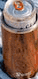

an image of a can


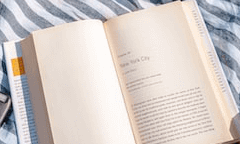

an image of a book


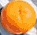

a picture of a fruit


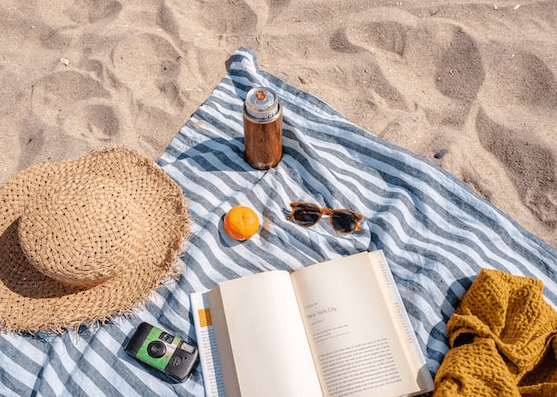

an image of sunglasses


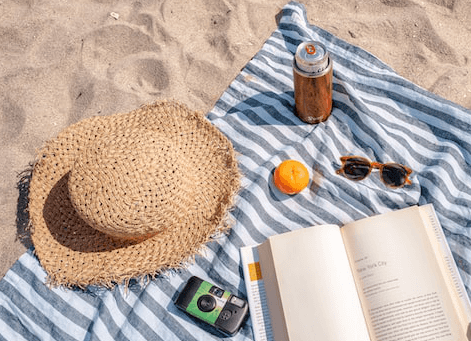

an image of sunglasses


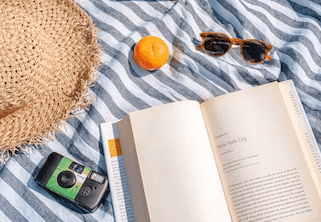

an image of sunglasses


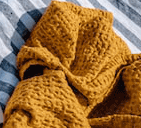

an image of clothing


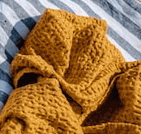

an image of clothing


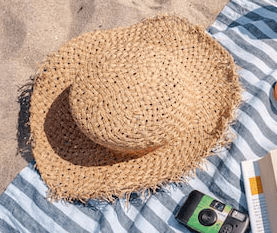

a photo of a hat


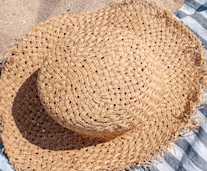

an image of a hat


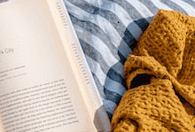

an image of a book


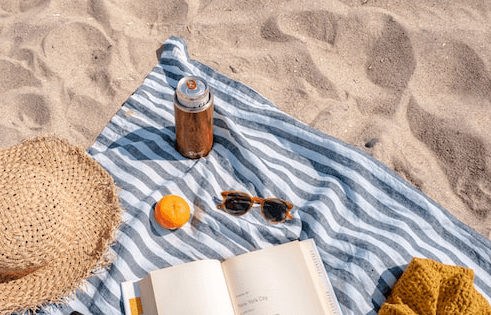

an image of sunglasses


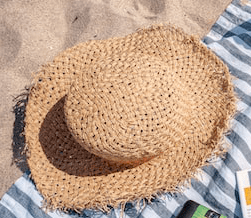

a photo of a hat


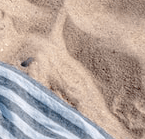

an image of a hat


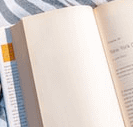

an image of a book


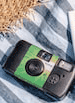

a photo of a camera


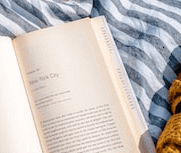

an image of a book


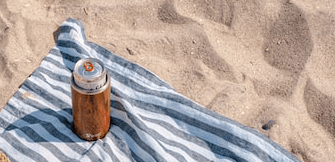

an image of a drink


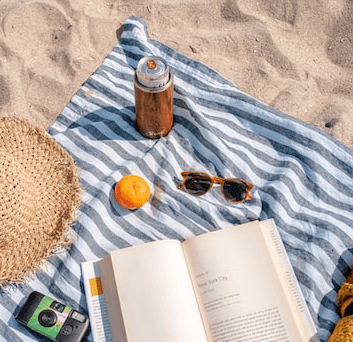

an image of sunglasses


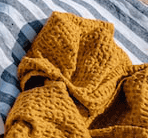

an image of clothing


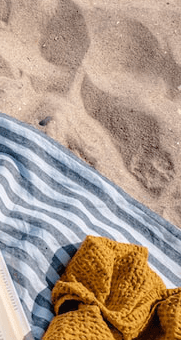

an image of a hat


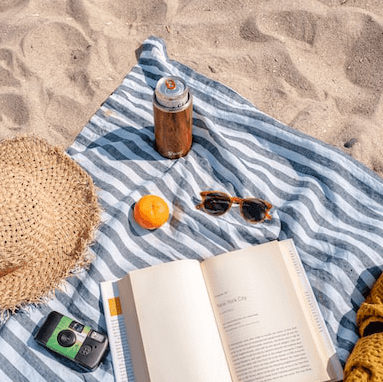

an image of sunglasses


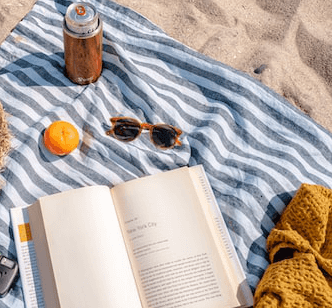

an image of sunglasses


In [47]:
best_matches = torch.argmax(similarities_per_image, dim=1)
for i, best_match in enumerate(best_matches):
    display(regions[i])
    print(queries[best_match])